In [18]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

# system ----
import os
import sys
import csv
import h5py
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# local ----
localPath = os.path.expanduser("~/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_003/")
sys.path.append(projPath+"modules")
import plot_parameters 

The fit for the ''cored-Einasto'' profile
\begin{align}
    \rho_{\rm cEin}(r) = \tilde{\rho}_{s} \exp\Bigg\{  -\frac{2}{\alpha}\Bigg[ \Big( \frac{r+r_{c}}{\tilde{r}_{s}}\Big)^{\alpha} - 1 \Bigg] \Bigg\}
\end{align}

its best to work with the logarithmic form to contain the simulated profile in the same order of magnitude for the curve fitting algorithm:

\begin{align}
    \log\rho_{\rm cEin}(r) = \log\tilde{\rho}_{s} - \frac{2}{\alpha}\Bigg[ \Big( \frac{r+r_{c}}{\tilde{r}_{s}}\Big)^{\alpha} - 1 \Bigg] 
\end{align}

In [50]:
def cein_density(r,rhos,rs,rc):
    alpha = 0.16
    A = np.power((rc+r)/rs,alpha)
    return rhos*np.exp(-(2./alpha)*(A-1.))

def cein_logdensity(r,logrhos,rs,rc):
    alpha = 0.16
    A = np.power((rc+r)/rs,alpha)
    return logrhos - (2./alpha)*(A-1.)

In [56]:
def fit_halo(haloName):
    results={}
    
    # loading halo density profile
    h5=h5py.File(projPath+'output/deprojection/'+str(haloName)+'.hdf5','r')
    rad=h5['profile:dm']['center:rockstar']['radial.bins'][:]
    den=h5['profile:dm']['center:rockstar']['density.bins:differential'][:]
    results['rad']=rad
    results['den']=den
    h5.close()
    
    # I did not demonstrate it here, but
    # it would probably be better to fit
    # the profile all the way down to the power radius 
    # (rpow~200kpc)
    
    # curve fit to cEinasto
    guess=(7., 1., 1.)
    blow=(0.,0.,0.)
    bupp=(np.inf,np.inf,np.inf)
    bound=(blow,bupp)
    popt,_=curve_fit(cein_logdensity,
                     rad,np.log(den), 
                     p0=guess,bounds=bound)

    results['rhos']=np.exp(popt[0])
    results['rs']=popt[1]
    results['rc']=popt[2]
    return results


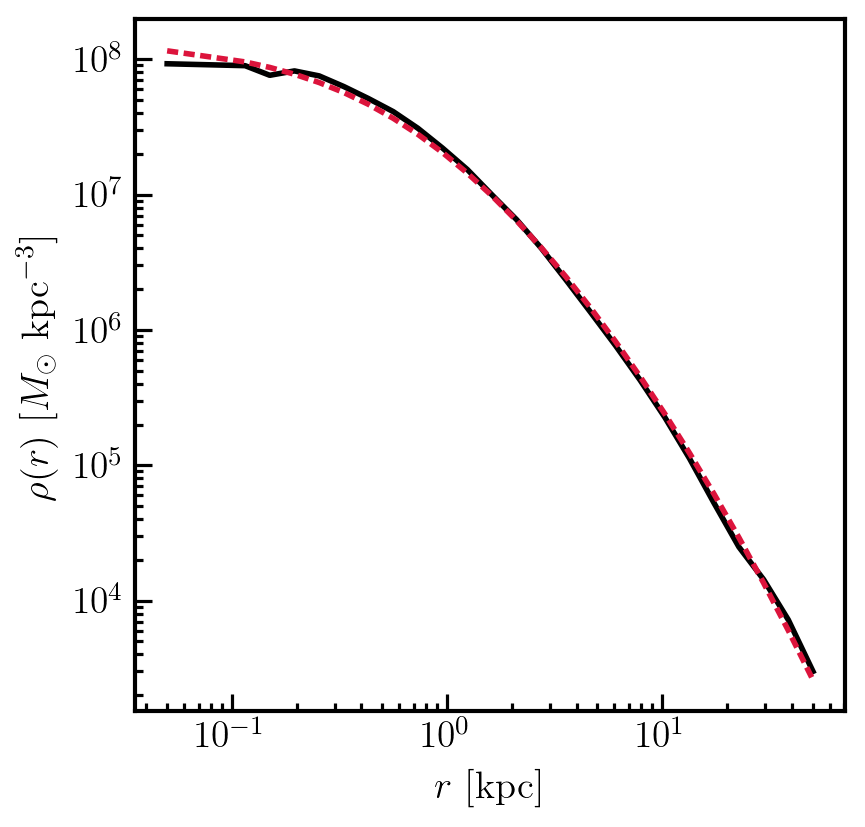

In [61]:
fig,axs=plt.subplots(figsize=(5.5/1.2, 5.5/1.2),dpi=100)
axs.xaxis.set_tick_params(direction='in', which='both')
axs.yaxis.set_tick_params(direction='in', which='both')

prof=fit_halo(haloName='m10l_res500.GVB');

axs.plot(prof['rad'],prof['den'],color='k')
axs.plot(prof['rad'],
         cein_density(prof['rad'],prof['rhos'],prof['rs'],prof['rc']),
         color='crimson',dashes=[2,1])

axs.set_xscale('log')
axs.set_yscale('log')

axs.set_xlabel(r'$r\ [\rm kpc]$')
axs.set_ylabel(r'$\rho(r)\ [M_{\odot}\ \rm kpc^{-3}]$')

plt.show()